# Hamza Omran

## Imports and Data Loading

In [25]:
import sys
sys.path.append("../src")

import pandas as pd
import numpy as np
from datetime import datetime

from data.loader import load_excel_sheets, summarize_excel_sheets
from analysis.supply_demand import (compute_category_supply, compute_category_demand, merge_supply_demand,
                                     compute_subcategory_supply, compute_subcategory_demand,
                                     compute_territory_demand, compute_subcategory_territory_demand)
from analysis.gap_score import (compute_gap_score, normalize_gap_score, classify_gap_level,
                                 compute_demand_supply_ratio, rank_categories_by_gap)
from visualization.static.gap_visualizer import (plot_gap_score_bar, plot_supply_vs_demand, plot_gap_dashboard,
                                                   plot_subcategory_gap_heatmap, plot_territory_gap_analysis,
                                                   plot_gap_by_region_category, plot_top_gaps_summary)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.options.display.float_format = '{:,.2f}'.format

file_path = "../data/processed/Cleaned_data.xlsx"
datasets = load_excel_sheets(file_path)

print("Datasets loaded successfully:")
print(list(datasets.keys()))

Datasets loaded successfully:
[' Product Lookup', 'Customer Lookup', 'Territory Lookup', 'Returns Data', 'Sales Data', 'Calendar Lookup', 'Product Subcategory', 'Product Category']


## Data Integration and Preparation

Merge product information with categories to enable category-level analysis.

In [26]:
product_lookup = datasets[' Product Lookup']
product_subcategory = datasets['Product Subcategory']
product_category = datasets['Product Category']
sales_data = datasets['Sales Data']

products_with_subcat = product_lookup.merge(
    product_subcategory,
    on='ProductSubcategoryKey',
    how='left'
)

products_full = products_with_subcat.merge(
    product_category,
    on='ProductCategoryKey',
    how='left'
)

sales_full = sales_data.merge(
    products_full[['ProductKey', 'CategoryName', 'SubcategoryName']],
    on='ProductKey',
    how='left'
)

print(f"Products with categories: {products_full.shape}")
print(f"Sales with categories: {sales_full.shape}")

display(products_full[['ProductKey', 'ProductName', 'CategoryName', 'SubcategoryName']].head())

Products with categories: (293, 15)
Sales with categories: (56046, 10)


,ProductKey,ProductName,CategoryName,SubcategoryName
0,214,"Sport-100 Helmet, Red",Accessories,Helmets
1,215,"Sport-100 Helmet, Black",Accessories,Helmets
2,218,"Mountain Bike Socks, M",Clothing,Socks
3,219,"Mountain Bike Socks, L",Clothing,Socks
4,220,"Sport-100 Helmet, Blue",Accessories,Helmets


## Supply Computation

In [27]:
supply_df = compute_category_supply(sales_data, products_full)

print("Category-Level Supply Metrics:")
display(supply_df.sort_values('UniqueProducts', ascending=False))

Category-Level Supply Metrics:


,CategoryName,UniqueProducts
3,Components,132
1,Bikes,97
2,Clothing,35
0,Accessories,29


## Demand Computation

Calculate demand metrics representing customer orders and sales volume per category.

In [28]:
demand_df = compute_category_demand(sales_full)

print("Category-Level Demand Metrics:")
display(demand_df.sort_values('TotalQuantitySold', ascending=False))

Category-Level Demand Metrics:


,CategoryName,UniqueOrders,TotalQuantitySold,UniqueCustomers
0,Accessories,16983,57809,14287
1,Bikes,13929,13929,8793
2,Clothing,6976,12436,6452


## Merge Supply and Demand

In [29]:
supply_demand_df = merge_supply_demand(supply_df, demand_df)

print("Merged Supply-Demand Dataset:")
display(supply_demand_df)

Merged Supply-Demand Dataset:


,CategoryName,UniqueOrders,TotalQuantitySold,UniqueCustomers,UniqueProducts
0,Accessories,16983,57809,14287,29
1,Bikes,13929,13929,8793,97
2,Clothing,6976,12436,6452,35
3,Components,0,0,0,132


## Gap Score Calculation

Compute the gap score using the formula:

**Gap Score = (Total Quantity Sold + 1) / (Unique Products + 1)**

The +1 adjustment prevents division by zero and provides meaningful scores even for categories with zero supply or demand.

In [30]:
gap_df = compute_gap_score(supply_demand_df, 
                           demand_col='TotalQuantitySold', 
                           supply_col='UniqueProducts')

print("Gap Scores Computed:")
display(gap_df.sort_values('GapScore', ascending=False))

Gap Scores Computed:


,CategoryName,UniqueOrders,TotalQuantitySold,UniqueCustomers,UniqueProducts,GapScore
0,Accessories,16983,57809,14287,29,"1,927.00"
2,Clothing,6976,12436,6452,35,345.47
1,Bikes,13929,13929,8793,97,142.14
3,Components,0,0,0,132,0.01


## Normalize and Classify Gap Scores

In [31]:
gap_df = normalize_gap_score(gap_df, gap_col='GapScore')
gap_df = classify_gap_level(gap_df, gap_col='GapScore')

print("Normalized and Classified Gap Scores:")
display(gap_df[['CategoryName', 'GapScore', 'NormalizedGapScore', 'GapLevel']])

Normalized and Classified Gap Scores:


,CategoryName,GapScore,NormalizedGapScore,GapLevel
0,Accessories,"1,927.00",1.00,Critical Gap
1,Bikes,142.14,0.07,High Gap
2,Clothing,345.47,0.18,Critical Gap
3,Components,0.01,0.00,Low Gap


## Compute Additional Metrics

Calculate supplementary metrics to provide deeper insights into supply-demand dynamics.

In [32]:
gap_df = compute_demand_supply_ratio(gap_df)

print("Complete Gap Analysis with other Metrics:")
display(gap_df)

Complete Gap Analysis with other Metrics:


,CategoryName,UniqueOrders,TotalQuantitySold,UniqueCustomers,UniqueProducts,GapScore,NormalizedGapScore,GapLevel,AvgQuantityPerProduct,AvgQuantityPerOrder,CustomerOrderRatio
0,Accessories,16983,57809,14287,29,"1,927.00",1.00,Critical Gap,"1,926.97",3.40,0.84
1,Bikes,13929,13929,8793,97,142.14,0.07,High Gap,142.13,1.00,0.63
2,Clothing,6976,12436,6452,35,345.47,0.18,Critical Gap,345.44,1.78,0.92
3,Components,0,0,0,132,0.01,0.00,Low Gap,0.00,0.00,0.00


## Rank Categories by Gap Severity

In [33]:
gap_df_ranked = rank_categories_by_gap(gap_df, gap_col='GapScore', ascending=False)

print("Categories Ranked by Gap Score (Highest First):")
display(gap_df_ranked[['Rank', 'CategoryName', 'GapScore', 'GapLevel', 'UniqueProducts', 'TotalQuantitySold']])

Categories Ranked by Gap Score (Highest First):


,Rank,CategoryName,GapScore,GapLevel,UniqueProducts,TotalQuantitySold
0,1,Accessories,"1,927.00",Critical Gap,29,57809
2,2,Clothing,345.47,Critical Gap,35,12436
1,3,Bikes,142.14,High Gap,97,13929
3,4,Components,0.01,Low Gap,132,0


## Visualization - Gap Score Bar Chart

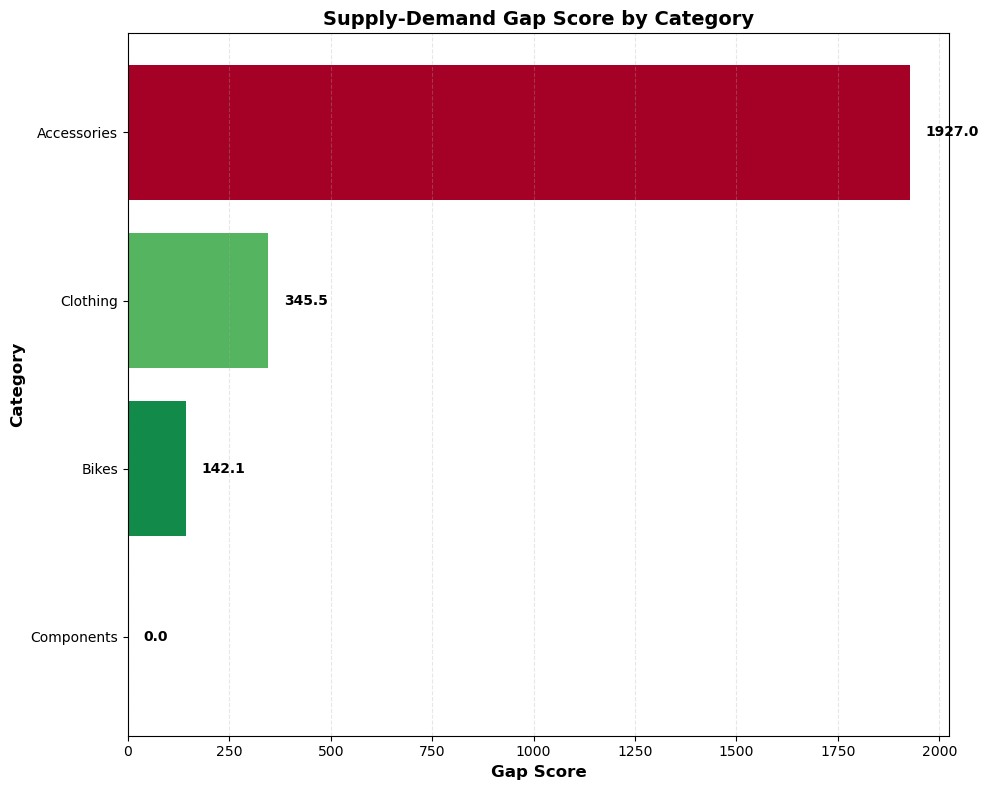

In [34]:
plot_gap_score_bar(gap_df_ranked, output_path='../results/charts/gap_score_bar.png')

## Visualization - Supply vs Demand Comparison

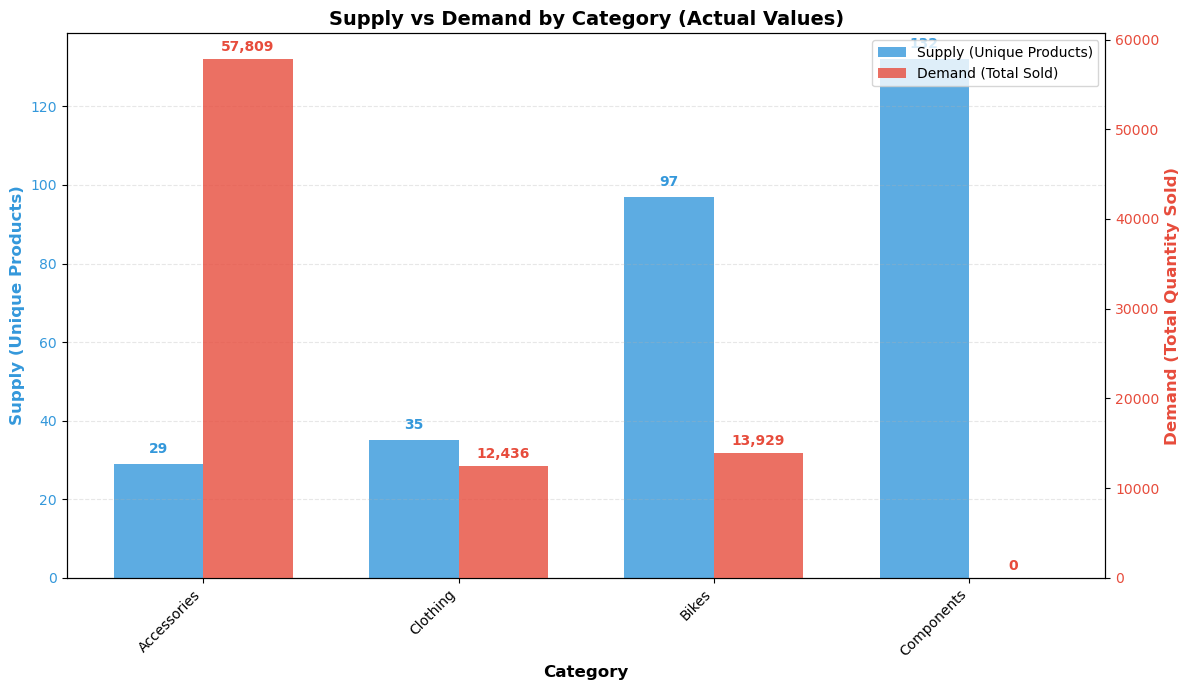

In [35]:
plot_supply_vs_demand(gap_df_ranked, output_path='../results/charts/supply_vs_demand.png')

## Visualization - Comprehensive Dashboard

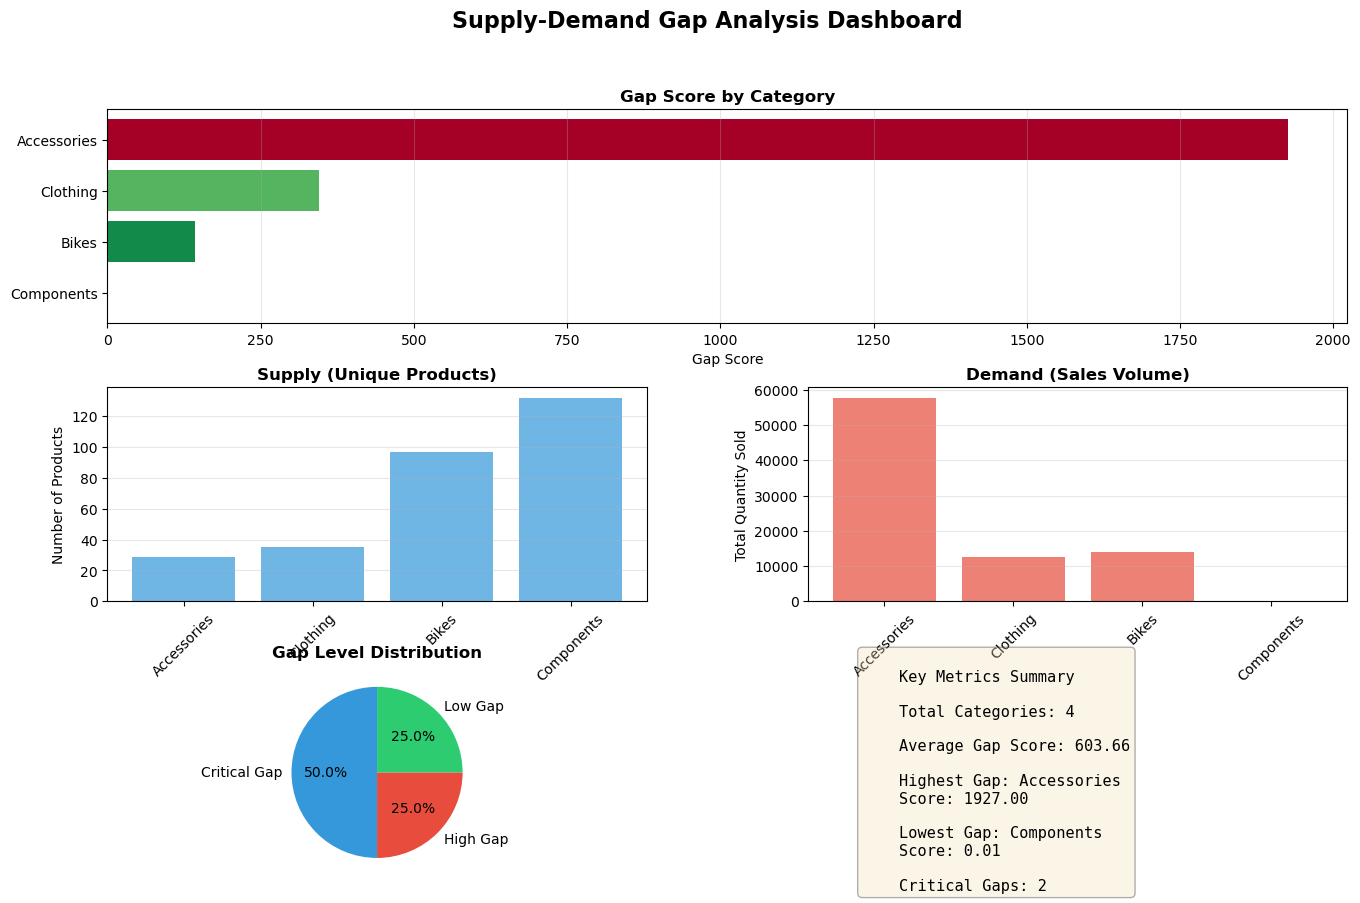

In [36]:
plot_gap_dashboard(gap_df_ranked, output_path='../results/charts/gap_dashboard.png')

## Key Insights and Interpretation

### Gap Analysis Summary

In [37]:
print("=" * 80)
print("GAP ANALYSIS - KEY INSIGHTS")
print("=" * 80)

highest_gap = gap_df_ranked.iloc[0]
print(f"\nHighest Gap Category: {highest_gap['CategoryName']}")
print(f"  - Gap Score: {highest_gap['GapScore']:.2f}")
print(f"  - Gap Level: {highest_gap['GapLevel']}")
print(f"  - Supply (Products): {int(highest_gap['UniqueProducts'])}")
print(f"  - Demand (Sales): {int(highest_gap['TotalQuantitySold'])}")
print(f"  - Recommendation: Increase supply by adding more product listings")

lowest_gap = gap_df_ranked.iloc[-1]
print(f"\nLowest Gap Category: {lowest_gap['CategoryName']}")
print(f"  - Gap Score: {lowest_gap['GapScore']:.2f}")
print(f"  - Gap Level: {lowest_gap['GapLevel']}")
print(f"  - Supply (Products): {int(lowest_gap['UniqueProducts'])}")
print(f"  - Demand (Sales): {int(lowest_gap['TotalQuantitySold'])}")
print(f"  - Status: Well-balanced supply and demand")

print(f"\nAverage Gap Score: {gap_df_ranked['GapScore'].mean():.2f}")
print(f"Standard Deviation: {gap_df_ranked['GapScore'].std():.2f}")

gap_level_counts = gap_df_ranked['GapLevel'].value_counts()
print("\nGap Level Distribution:")
for level, count in gap_level_counts.items():
    print(f"  - {level}: {count} categories")

print("=" * 80)

GAP ANALYSIS - KEY INSIGHTS

Highest Gap Category: Accessories
  - Gap Score: 1927.00
  - Gap Level: Critical Gap
  - Supply (Products): 29
  - Demand (Sales): 57809
  - Recommendation: Increase supply by adding more product listings

Lowest Gap Category: Components
  - Gap Score: 0.01
  - Gap Level: Low Gap
  - Supply (Products): 132
  - Demand (Sales): 0
  - Status: Well-balanced supply and demand

Average Gap Score: 603.66
Standard Deviation: 893.55

Gap Level Distribution:
  - Critical Gap: 2 categories
  - High Gap: 1 categories
  - Low Gap: 1 categories


## Subcategory-Level Gap Analysis

In [38]:
subcategory_supply = compute_subcategory_supply(sales_data, products_full)
print("Subcategory-Level Supply:")
display(subcategory_supply.head(10))

sales_with_subcat = sales_full.copy()
subcategory_demand = compute_subcategory_demand(sales_with_subcat)
print("\nSubcategory-Level Demand:")
display(subcategory_demand.head(10))

Subcategory-Level Supply:


,CategoryName,SubcategoryName,UniqueProducts
0,Accessories,Bike Racks,1
1,Accessories,Bike Stands,1
2,Accessories,Bottles and Cages,3
3,Accessories,Cleaners,1
4,Accessories,Fenders,1
5,Accessories,Helmets,3
6,Accessories,Hydration Packs,1
7,Accessories,Lights,3
8,Accessories,Locks,1
9,Accessories,Panniers,1



Subcategory-Level Demand:


,CategoryName,SubcategoryName,UniqueOrders,TotalQuantitySold,UniqueCustomers
0,Accessories,Bike Racks,302,302,300
1,Accessories,Bike Stands,234,234,231
2,Accessories,Bottles and Cages,4485,15106,4288
3,Accessories,Cleaners,850,1706,823
4,Accessories,Fenders,1975,3960,1965
5,Accessories,Helmets,6034,6034,5620
6,Accessories,Hydration Packs,695,695,682
7,Accessories,Tires and Tubes,9084,29772,7924
8,Bikes,Mountain Bikes,4706,4706,3950
9,Bikes,Road Bikes,7099,7099,5728


### Merge and Compute Subcategory Gap Scores

In [39]:
subcategory_supply_demand = merge_supply_demand(subcategory_supply, subcategory_demand)

subcategory_gaps = compute_gap_score(subcategory_supply_demand, 
                                     demand_col='TotalQuantitySold', 
                                     supply_col='UniqueProducts')

subcategory_gaps = normalize_gap_score(subcategory_gaps, gap_col='GapScore')
subcategory_gaps = classify_gap_level(subcategory_gaps, gap_col='GapScore')
subcategory_gaps = compute_demand_supply_ratio(subcategory_gaps)
subcategory_gaps = rank_categories_by_gap(subcategory_gaps, gap_col='GapScore', ascending=False)

print("Top 15 Subcategories by Gap Score:")
display(subcategory_gaps[['Rank', 'CategoryName', 'SubcategoryName', 'GapScore', 
                          'GapLevel', 'UniqueProducts', 'TotalQuantitySold']].head(15))

Top 15 Subcategories by Gap Score:


,Rank,CategoryName,SubcategoryName,GapScore,GapLevel,UniqueProducts,TotalQuantitySold
2,1,Accessories,Bottles and Cages,"3,776.75",Critical Gap,3,15106
11,2,Accessories,Tires and Tubes,"2,481.08",Critical Gap,11,29772
16,3,Clothing,Caps,"2,076.00",Critical Gap,1,4151
4,4,Accessories,Fenders,"1,980.50",Critical Gap,1,3960
5,5,Accessories,Helmets,"1,508.75",Critical Gap,3,6034
3,6,Accessories,Cleaners,853.50,Critical Gap,1,1706
17,7,Clothing,Gloves,377.86,Critical Gap,6,2644
6,8,Accessories,Hydration Packs,348.00,Critical Gap,1,695
18,9,Clothing,Jerseys,346.00,Critical Gap,8,3113
20,10,Clothing,Socks,212.80,Critical Gap,4,1063


### Visualize Subcategory Gaps

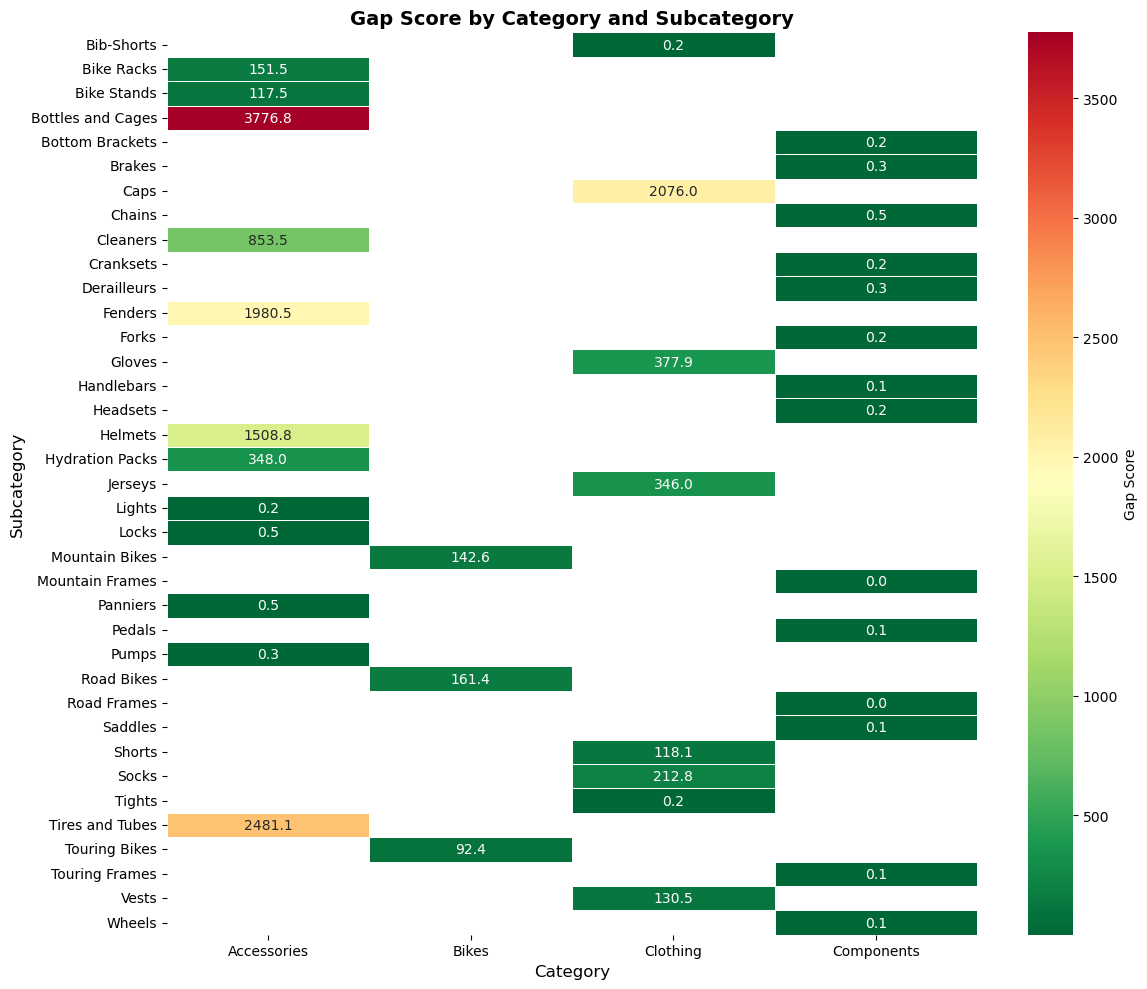

In [40]:
plot_subcategory_gap_heatmap(subcategory_gaps, output_path='../results/charts/subcategory_gap_heatmap.png')

## Territory-Level Gap Analysis

In [41]:
territory_lookup = datasets['Territory Lookup']

territory_demand = compute_territory_demand(sales_full, territory_lookup)
print("Territory-Level Demand by Category:")
display(territory_demand.head(10))

Territory-Level Demand by Category:


,Region,Country,CategoryName,UniqueOrders,TotalQuantitySold,UniqueCustomers
0,Australia,Australia,Accessories,3477,11360,2797
1,Australia,Australia,Bikes,4019,4019,2125
2,Australia,Australia,Clothing,1466,2572,1366
3,Canada,Canada,Accessories,2331,8298,1166
4,Canada,Canada,Bikes,858,858,638
5,Canada,Canada,Clothing,946,1738,666
6,Central,United States,Accessories,7,22,7
7,Central,United States,Bikes,2,2,2
8,Central,United States,Clothing,4,6,4
9,France,France,Accessories,1588,5419,1413


### Compute Territory Gap Scores In Each Category

In [42]:
territory_supply = products_full.groupby('CategoryName').agg({
    'ProductKey': 'nunique'
}).reset_index()
territory_supply.columns = ['CategoryName', 'UniqueProducts']

territory_gaps_list = []

for _, row in territory_demand.iterrows():
    category = row['CategoryName']
    supply_info = territory_supply[territory_supply['CategoryName'] == category]
    
    if len(supply_info) > 0:
        supply_count = supply_info.iloc[0]['UniqueProducts']
    else:
        supply_count = 0
    
    gap_score = (row['TotalQuantitySold'] + 1) / (supply_count + 1)
    
    territory_gaps_list.append({
        'Region': row['Region'],
        'Country': row['Country'],
        'CategoryName': row['CategoryName'],
        'UniqueProducts': supply_count,
        'TotalQuantitySold': row['TotalQuantitySold'],
        'UniqueOrders': row['UniqueOrders'],
        'UniqueCustomers': row['UniqueCustomers'],
        'GapScore': round(gap_score, 2)
    })

territory_gaps = pd.DataFrame(territory_gaps_list)
territory_gaps = normalize_gap_score(territory_gaps, gap_col='GapScore')
territory_gaps = classify_gap_level(territory_gaps, gap_col='GapScore')

print("Territory Gap Analysis:")
display(territory_gaps.sort_values('GapScore', ascending=False).head(15))

Territory Gap Analysis:


,Region,Country,CategoryName,UniqueProducts,TotalQuantitySold,UniqueOrders,UniqueCustomers,GapScore,NormalizedGapScore,GapLevel
24,Southwest,United States,Accessories,29,11852,3485,3360,395.10,1.00,Critical Gap
0,Australia,Australia,Accessories,29,11360,3477,2797,378.70,0.96,Critical Gap
18,Northwest,United States,Accessories,29,8872,2596,2493,295.77,0.75,Critical Gap
3,Canada,Canada,Accessories,29,8298,2331,1166,276.63,0.70,Critical Gap
27,United Kingdom,United Kingdom,Accessories,29,6563,1908,1590,218.80,0.55,Critical Gap
9,France,France,Accessories,29,5419,1588,1413,180.67,0.46,High Gap
12,Germany,Germany,Accessories,29,5358,1572,1444,178.63,0.45,High Gap
26,Southwest,United States,Clothing,35,2600,1447,1427,72.25,0.18,Moderate Gap
2,Australia,Australia,Clothing,35,2572,1466,1366,71.47,0.18,Moderate Gap
20,Northwest,United States,Clothing,35,1905,1073,1062,52.94,0.13,Moderate Gap


### Visualize Territory Gaps

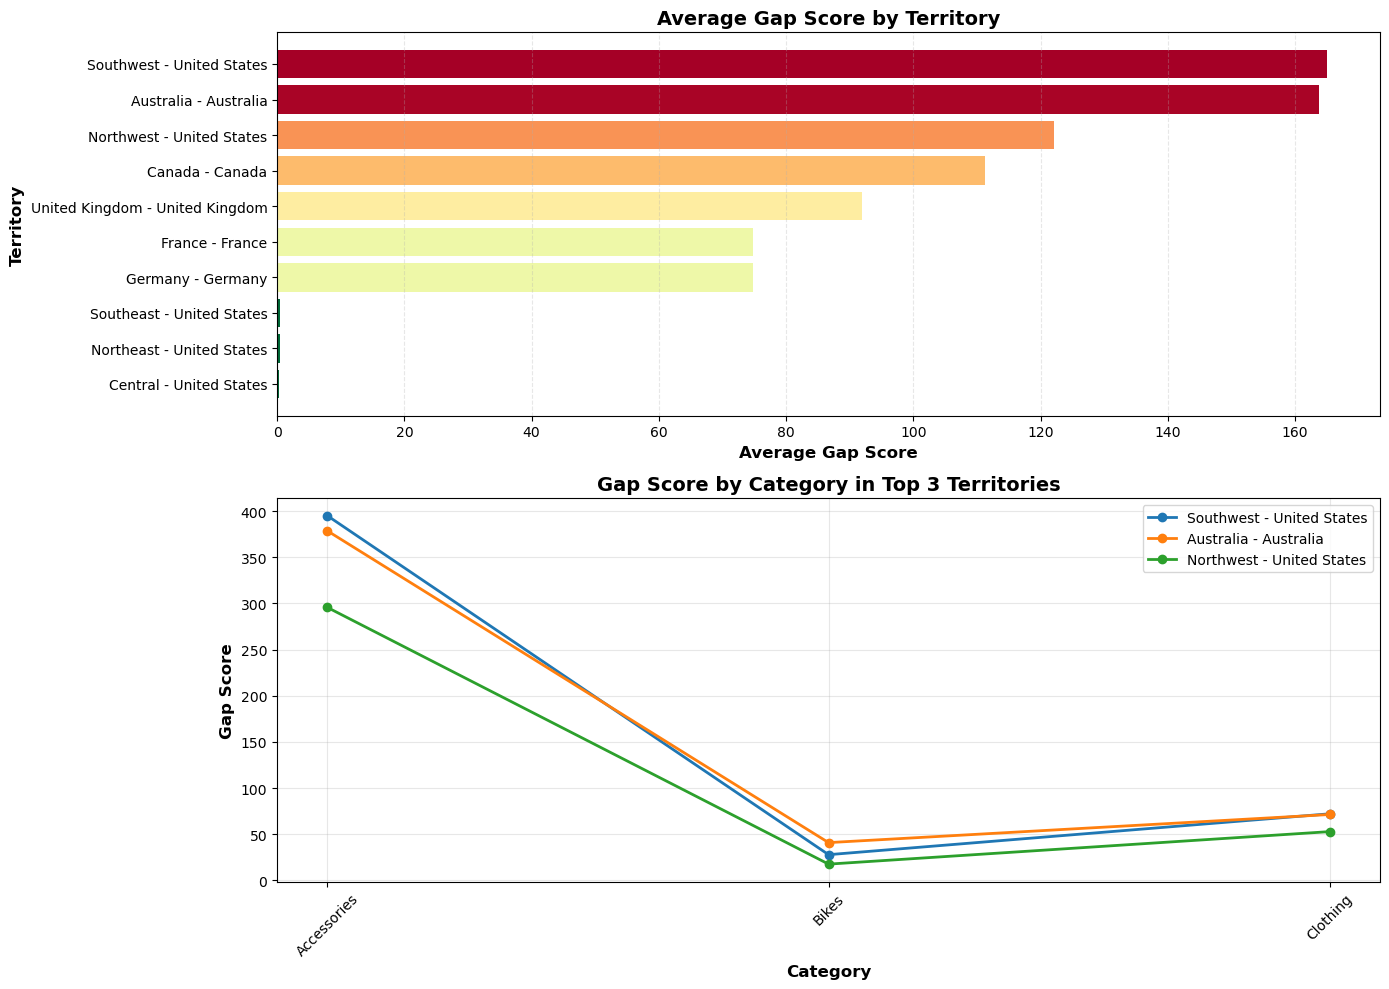

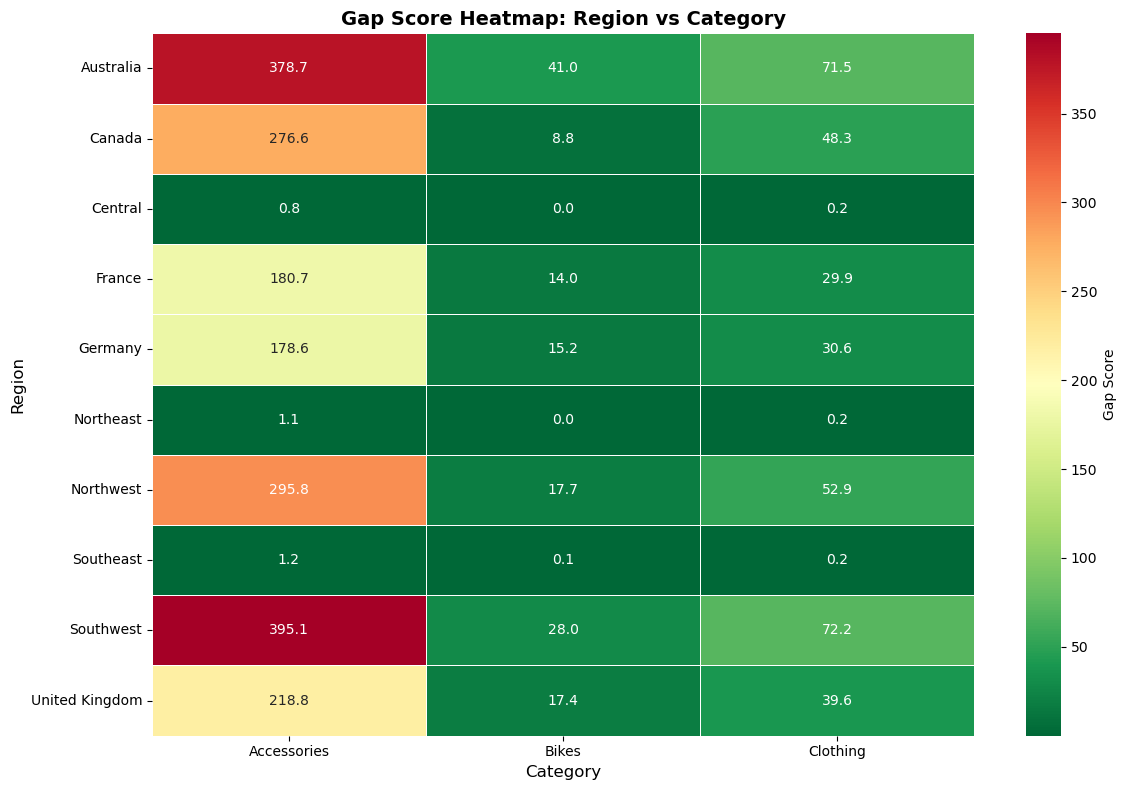

In [43]:
plot_territory_gap_analysis(territory_gaps, output_path='../results/charts/territory_gap_analysis.png')

plot_gap_by_region_category(territory_gaps, output_path='../results/charts/region_category_heatmap.png')

## Comprehensive Gap Summary Dashboard

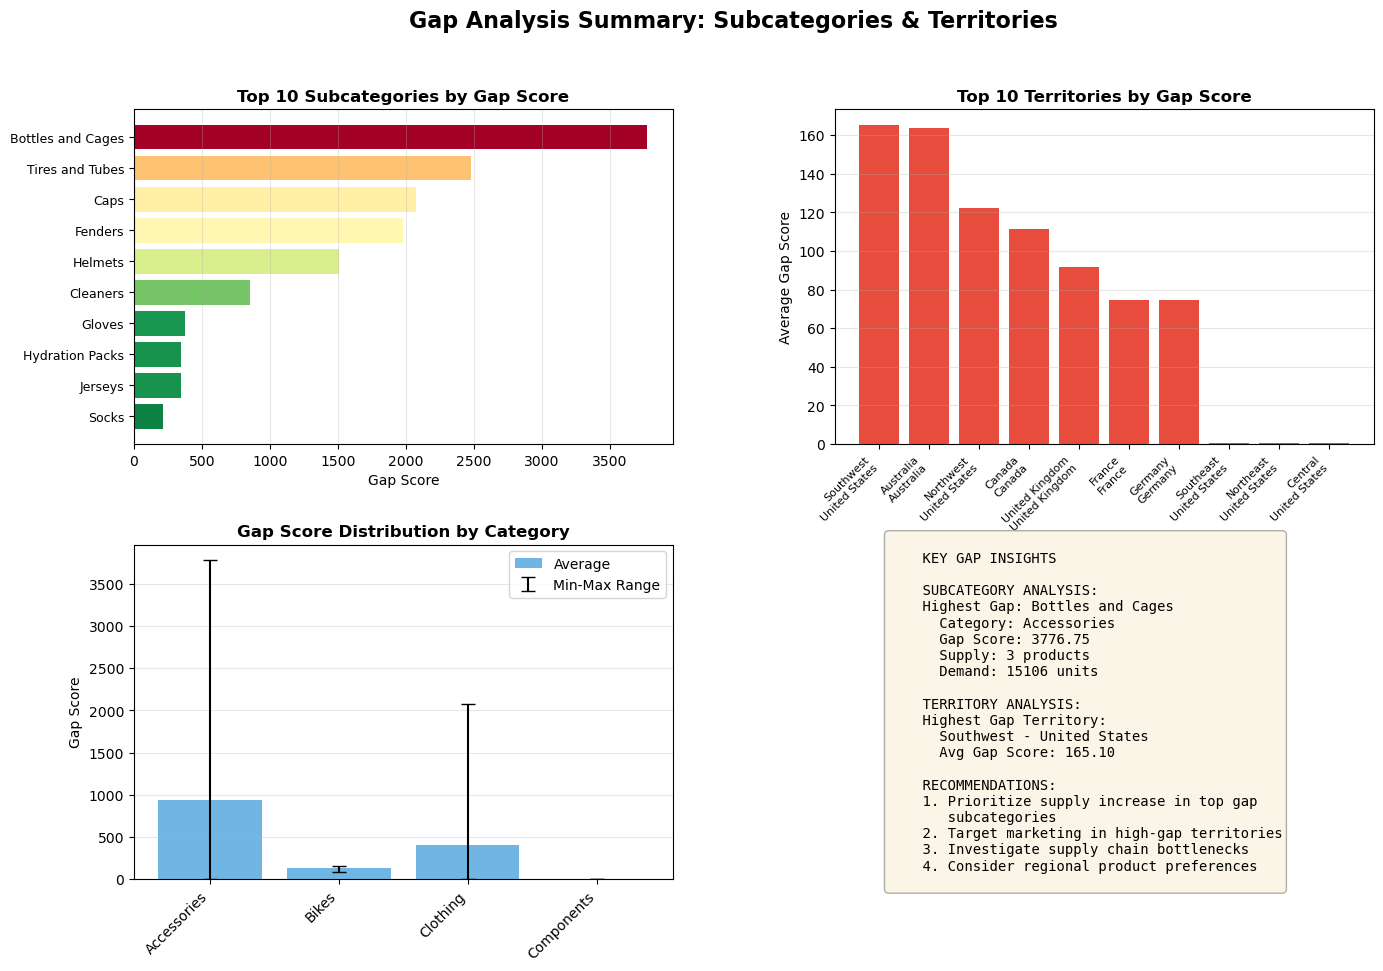

In [44]:
plot_top_gaps_summary(subcategory_gaps, territory_gaps, top_n=10, output_path='../results/charts/comprehensive_gap_summary.png')

## Detailed Gap Insights by Territory and Subcategory Combination

In [45]:
subcategory_territory_demand = compute_subcategory_territory_demand(sales_full, territory_lookup)

print("Subcategory-Territory Demand:")
display(subcategory_territory_demand.head(15))

subcategory_territory_gaps_list = []

for _, row in subcategory_territory_demand.iterrows():
    category = row['CategoryName']
    subcategory = row['SubcategoryName']
    
    supply_info = products_full[
        (products_full['CategoryName'] == category) & 
        (products_full['SubcategoryName'] == subcategory)
    ]
    supply_count = supply_info['ProductKey'].nunique()
    
    gap_score = (row['TotalQuantitySold'] + 1) / (supply_count + 1)
    
    subcategory_territory_gaps_list.append({
        'Region': row['Region'],
        'Country': row['Country'],
        'CategoryName': row['CategoryName'],
        'SubcategoryName': row['SubcategoryName'],
        'UniqueProducts': supply_count,
        'TotalQuantitySold': row['TotalQuantitySold'],
        'UniqueOrders': row['UniqueOrders'],
        'UniqueCustomers': row['UniqueCustomers'],
        'GapScore': round(gap_score, 2)
    })

subcategory_territory_gaps = pd.DataFrame(subcategory_territory_gaps_list)
subcategory_territory_gaps = normalize_gap_score(subcategory_territory_gaps, gap_col='GapScore')
subcategory_territory_gaps = classify_gap_level(subcategory_territory_gaps, gap_col='GapScore')

print("\nTop 20 Territory-Subcategory Gaps:")
display(subcategory_territory_gaps.sort_values('GapScore', ascending=False).head(20))

Subcategory-Territory Demand:


,Region,Country,CategoryName,SubcategoryName,UniqueOrders,TotalQuantitySold,UniqueCustomers
0,Australia,Australia,Accessories,Bike Racks,46,46,46
1,Australia,Australia,Accessories,Bike Stands,59,59,58
2,Australia,Australia,Accessories,Bottles and Cages,864,3019,838
3,Australia,Australia,Accessories,Cleaners,207,423,203
4,Australia,Australia,Accessories,Fenders,307,617,307
5,Australia,Australia,Accessories,Helmets,1229,1229,1165
6,Australia,Australia,Accessories,Hydration Packs,182,182,180
7,Australia,Australia,Accessories,Tires and Tubes,1738,5785,1522
8,Australia,Australia,Bikes,Mountain Bikes,1207,1207,727
9,Australia,Australia,Bikes,Road Bikes,2271,2271,1327



Top 20 Territory-Subcategory Gaps:


,Region,Country,CategoryName,SubcategoryName,UniqueProducts,TotalQuantitySold,UniqueOrders,UniqueCustomers,GapScore,NormalizedGapScore,GapLevel
117,Southwest,United States,Accessories,Bottles and Cages,3,3276,972,971,819.25,1.00,Critical Gap
2,Australia,Australia,Accessories,Bottles and Cages,3,3019,864,838,755.00,0.92,Critical Gap
88,Northwest,United States,Accessories,Bottles and Cages,3,2277,691,691,569.50,0.70,Critical Gap
119,Southwest,United States,Accessories,Fenders,1,1069,532,532,535.00,0.65,Critical Gap
19,Canada,Canada,Accessories,Bottles and Cages,3,1986,619,527,496.75,0.61,Critical Gap
7,Australia,Australia,Accessories,Tires and Tubes,11,5785,1738,1522,482.17,0.59,Critical Gap
122,Southwest,United States,Accessories,Tires and Tubes,11,5697,1778,1719,474.83,0.58,Critical Gap
134,United Kingdom,United Kingdom,Accessories,Bottles and Cages,3,1760,516,488,440.25,0.54,Critical Gap
11,Australia,Australia,Clothing,Caps,1,820,405,400,410.50,0.50,Critical Gap
90,Northwest,United States,Accessories,Fenders,1,768,390,390,384.50,0.47,Critical Gap


## Export Comprehensive Gap Analysis Results

In [46]:
import os

comprehensive_output_path = "../results/reports/comprehensive_gap_analysis.xlsx"

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(comprehensive_output_path), exist_ok=True)

with pd.ExcelWriter(comprehensive_output_path, engine='openpyxl') as writer:
    gap_df_ranked.to_excel(writer, sheet_name='Category Gaps', index=False)
    subcategory_gaps.to_excel(writer, sheet_name='Subcategory Gaps', index=False)
    territory_gaps.to_excel(writer, sheet_name='Territory Gaps', index=False)
    subcategory_territory_gaps.to_excel(writer, sheet_name='Detailed Gaps', index=False)

print(f"Comprehensive gap analysis exported to: {comprehensive_output_path}")
print("\nSheets included:")
print("  1. Category Gaps - Overall category-level analysis")
print("  2. Subcategory Gaps - Granular subcategory analysis")
print("  3. Territory Gaps - Regional gap distribution")
print("  4. Detailed Gaps - Subcategory × Territory combinations")

Comprehensive gap analysis exported to: ../results/reports/comprehensive_gap_analysis.xlsx

Sheets included:
  1. Category Gaps - Overall category-level analysis
  2. Subcategory Gaps - Granular subcategory analysis
  3. Territory Gaps - Regional gap distribution
  4. Detailed Gaps - Subcategory × Territory combinations


## Where Are the Gaps?

### Summary of Gap Locations

In [47]:
print("=" * 100)
print("WHERE ARE THE GAPS?")
print("=" * 100)

print("\n1. HIGHEST GAP SUBCATEGORIES:")
print("-" * 100)
for idx, row in subcategory_gaps.head(5).iterrows():
    print(f"\n   {row['Rank']}. {row['SubcategoryName']} ({row['CategoryName']})")
    print(f"      Gap Score: {row['GapScore']:.2f} | Level: {row['GapLevel']}")
    print(f"      Supply: {int(row['UniqueProducts'])} products | Demand: {int(row['TotalQuantitySold'])} units")

print("\n\n2. HIGHEST GAP TERRITORIES:")
print("-" * 100)
territory_summary = territory_gaps.groupby(['Region', 'Country'])['GapScore'].mean().reset_index()
territory_summary = territory_summary.sort_values('GapScore', ascending=False)

for idx, row in territory_summary.head(5).iterrows():
    print(f"\n   {idx+1}. {row['Region']} - {row['Country']}")
    print(f"      Average Gap Score: {row['GapScore']:.2f}")
    
    territory_categories = territory_gaps[
        (territory_gaps['Region'] == row['Region']) & 
        (territory_gaps['Country'] == row['Country'])
    ].sort_values('GapScore', ascending=False)
    
    print(f"      Top Gap Categories:")
    for _, cat_row in territory_categories.head(3).iterrows():
        print(f"        - {cat_row['CategoryName']}: {cat_row['GapScore']:.2f}")

print("\n\n3. CRITICAL GAP COMBINATIONS (Territory × Subcategory):")
print("-" * 100)
critical_gaps = subcategory_territory_gaps[
    subcategory_territory_gaps['GapLevel'].isin(['Critical Gap', 'High Gap'])
].sort_values('GapScore', ascending=False).head(10)

for idx, row in critical_gaps.iterrows():
    print(f"\n   {row['Region']} - {row['Country']} | {row['SubcategoryName']}")
    print(f"   Gap Score: {row['GapScore']:.2f} | Supply: {int(row['UniqueProducts'])} | Demand: {int(row['TotalQuantitySold'])}")

print("\n" + "=" * 100)

WHERE ARE THE GAPS?

1. HIGHEST GAP SUBCATEGORIES:
----------------------------------------------------------------------------------------------------

   1. Bottles and Cages (Accessories)
      Gap Score: 3776.75 | Level: Critical Gap
      Supply: 3 products | Demand: 15106 units

   2. Tires and Tubes (Accessories)
      Gap Score: 2481.08 | Level: Critical Gap
      Supply: 11 products | Demand: 29772 units

   3. Caps (Clothing)
      Gap Score: 2076.00 | Level: Critical Gap
      Supply: 1 products | Demand: 4151 units

   4. Fenders (Accessories)
      Gap Score: 1980.50 | Level: Critical Gap
      Supply: 1 products | Demand: 3960 units

   5. Helmets (Accessories)
      Gap Score: 1508.75 | Level: Critical Gap
      Supply: 3 products | Demand: 6034 units


2. HIGHEST GAP TERRITORIES:
----------------------------------------------------------------------------------------------------

   9. Southwest - United States
      Average Gap Score: 165.10
      Top Gap Categories:
 